## Evaluation Framework for NL-to-SQL
This is a framework for evaluating the performance of NL-to-SQL capabilities of Open AI models.

### 1. Import required modules and plugins

In [4]:
import pandas as pd
import statistics
import os
from dotenv import load_dotenv

import semantic_kernel as sk
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion

from plugins.techniques.match import ExactMatch
from plugins.techniques.token import TokenBasedSimilarity
from plugins.techniques.semantic import SemanticAccuracy
from plugins.techniques.structure import StructuralSimilarity
from plugins.connectors.sqlconnector import SQLConnection

### 2. Initialize Semantic Kernel and load configuration settings

In [ ]:
# Init Semantic Kernel..
kernel = sk.Kernel()

# Init SKContext..
context = kernel.create_new_context()

# Configure AI service used by the kernel..
deployment, api_key, endpoint = sk.azure_openai_settings_from_dot_env()
kernel.add_text_completion_service(
    "gpt35", AzureChatCompletion(deployment, endpoint, api_key)
)

"""
useAzureOpenAI = True
if useAzureOpenAI:
    deployment, api_key, endpoint = sk.azure_openai_settings_from_dot_env()
    kernel.add_text_completion_service("gpt35", AzureChatCompletion(deployment, endpoint, api_key))
else:
    api_key, org_id = sk.openai_settings_from_dot_env()
    kernel.add_text_completion_service("gpt35", OpenAITextCompletion("text-davinci-003", api_key, org_id))
"""

# Add open ai settings to context..
context["deployment"] = deployment
context["api_key"] = api_key
context["endpoint"] = endpoint

# Configure Embeddings deployment and SQL Server configuration..
load_dotenv()
embeddings_deployment = os.getenv("AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT_NAME")
sql_server_name = os.getenv("AZURE_SQL_SERVER_NAME")
sql_server_database_name = os.getenv("AZURE_SQL_SERVER_DATABASE_NAME")
sql_server_username = os.getenv("AZURE_SQL_SERVER_USERNAME")
sql_server_password = os.getenv("AZURE_SQL_SERVER_PASSWORD")
sql_server_odbc_driver = os.getenv("AZURE_SQL_ODBC_DRIVER")

# Add embeddings deployment and sql server settings to context..
context["embeddings_deployment"] = embeddings_deployment
context["sql_server_name"] = sql_server_name
context["sql_server_database_name"] = sql_server_database_name
context["sql_server_username"] = sql_server_username
context["sql_server_password"] = sql_server_password
context["sql_server_odbc_driver"] = sql_server_odbc_driver

# Print settings for checking..
# print("useAzureOpenAI=", useAzureOpenAI)
print("-- Azure Open AI Service configurations --")
print("AZURE_OPENAI_DEPLOYMENT_NAME=", deployment)
print("AZURE_OPENAI_ENDPOINT=", endpoint)
print("AZURE_OPENAI_API_KEY=", api_key)
print("AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT_NAME=", context["embeddings_deployment"])
print("-- Azure SQL Server configurations --")
print("AZURE_SQL_SERVER_NAME=", sql_server_name)
print("AZURE_SQL_SERVER_DATABASE_NAME=", sql_server_database_name)
print("AZURE_SQL_SERVER_USERNAME=", sql_server_username)
print("AZURE_SQL_SERVER_PASSWORD=", sql_server_password)
print("AZURE_SQL_ODBC_DRIVER=", sql_server_odbc_driver)

### 3. Import required functions from plugins

In [6]:
# Load plugins and functions.
# Import plugins.
nltosql_plugin = kernel.import_semantic_skill_from_directory("plugins", "techniques")
exact_match = kernel.import_skill(ExactMatch())
token_based_similarity = kernel.import_skill(TokenBasedSimilarity())
sql_connection = kernel.import_skill(SQLConnection())
semantic_accuracy = kernel.import_skill(SemanticAccuracy())
structural_similarity = kernel.import_skill(StructuralSimilarity())

# Get functions from plugins
convert_nltosql = nltosql_plugin["NLtoSQL"]
check_exact_match = exact_match["check_exact_match"]
calc_levenshtein_distance = token_based_similarity["calc_levenshtein_distance"]
calc_cosine_similarity = token_based_similarity["calc_cosine_similarity"]
check_sql_syntax = sql_connection["check_sql_syntax"]
execute = sql_connection["execute"]
check_result_match = semantic_accuracy["check_result_match"]
compare_sql = structural_similarity["compare_sql"]

### 4. Load input dataset
Input dataset should be a csv format and contain NL,SQL pairs.

NL is a natual language input from a user and SQL is an expected SQL statement generated by Open AI.

Please see data/input/sample_NLtoSQL.csv

In [7]:
# Load the input data
df = pd.read_csv("data/input/sample_NLtoSQL.csv")
df.head()

,NL,SQL
0,Get count of each size,"SELECT Size, Count(*) as count FROM [SalesLT]...."
1,Get all product names,SELECT Name FROM [SalesLT].[Product]
2,Get average of UnitPrice in actual Sales order,SELECT AVG(UnitPrice) FROM [SalesLT].[SalesOrd...
3,How many Sales order were there?,SELECT COUNT(SalesOrderID) FROM [SalesLT].[Sal...
4,How many products are there for each color?,"SELECT COUNT(*), Color FROM [SalesLT].[Product..."


## Main Process
1. read prompt(NL) and expected query(SQL) from test dataset.
1. call nl-to-sql plugin to generate sql from nl by calling Open AI.
1. check Exact Match.
1. get resultset, syntax validity and performance by executing expected sql and generated sql on Azuer SQL Server.
1. check Resultset Match = Semantic Accuray.
1. calc Levenshtein Distance Score.
1. calc cosine similarity.

In [8]:
# variables..
gen_query, exp_result, gen_result = [], [], []
q_exa_match, lev_score, cos_sim, semantic_acc = [], [], [], []
syn_valid, syn_error, q_diff = [], [], []
exp_q_perf, gen_q_perf, perf_diff = [], [], []

# Loop with loaded input dataset..
for inx in range(len(df)):
    ## Print processing line..
    print("#", inx + 1, "processing...")

    ## 1. read prompt(NL) and expected query(SQL) from test dataset.
    nl = df["NL"][inx]
    expected_query = df["SQL"][inx]
    context["expected_str"] = expected_query

    ## call nl-to-sql plugin to generate sql from nl by calling Open AI..
    generated_query = "SELECT " + convert_nltosql(nl).result
    context["generated_str"] = generated_query

    ## print nl, expected sql and generated sql..
    print("  > NL input =", nl)
    print("    - Expected SQL  =", expected_query)
    print("    - Generated SQL =", generated_query)

    ## Start calculating metrics..
    print("  > Metrics")

    ## 3. check Exact Match
    query_exact_match = eval(check_exact_match(context=context).result)
    print("    - Query Exact Match=   ", query_exact_match)

    ## 4. Check Query Diff
    if not query_exact_match:
        query_diff = compare_sql(context=context).result
        print("    - Query Diff\n", query_diff)
    else:
        query_diff = ""

    ## 5. get result set, syntax validity and performance by executing expected sql and generated sql on Azure SQL Server..
    #  5.1 execute expected sql..
    context["sql"] = expected_query
    executed = eval(execute(context=context).result)
    if executed:
        expected_result = context["result_set"]
        context["expected_result"] = expected_result
        print("    - Expected Results=    ", expected_result)

        exp_query_perf = float(context["elapsed_time"])
        print("    - Expected query perf= ", exp_query_perf)
    else:
        print("sql_error:", context["sql_error"])

    #  5.3 execute generated sql..
    error_message = ""
    query_syntax_valid = True
    context["sql"] = generated_query
    executed = eval(execute(context=context).result)
    if executed:
        generated_result = context["result_set"]
        context["generated_result"] = generated_result
        print("    - Generated Results=   ", generated_result)

        gen_query_perf = float(context["elapsed_time"])
        print("    - Generated query perf=", gen_query_perf)
    else:
        query_syntax_valid = False
        error_message = context["sql_error"]
        print("sql_error:", error_message)

    ## 6. check Result Match = Semantic Accuracy
    semantic_accuracy = eval(check_result_match(context=context).result)
    print("    - Result Set Match=     ", semantic_accuracy)

    ## 7. calc Levenshtein Distance Score
    levenshtein_score = float(calc_levenshtein_distance(context=context).result)
    print("    - levenshtein Score=   ", levenshtein_score)

    # 8. calc cosine similarity..
    cos_similarity = float(calc_cosine_similarity(context=context).result)
    print("    - Cosine Similarity=  ", cos_similarity)

    # 9. appending metrics results to data frame..
    gen_query.append(generated_query)
    q_exa_match.append(query_exact_match)
    q_diff.append(query_diff)
    exp_result.append(expected_result)
    exp_q_perf.append(exp_query_perf)
    gen_result.append(generated_result)
    gen_q_perf.append(gen_query_perf)
    perf_diff.append(gen_query_perf - exp_query_perf)
    syn_error.append(error_message)
    syn_valid.append(query_syntax_valid)
    semantic_acc.append(semantic_accuracy)
    lev_score.append(levenshtein_score)
    cos_sim.append(cos_similarity)

## Adding results to a report..
df["Generated Query"] = gen_query
df["Syntax Valid"] = syn_valid
df["Syntax Error"] = syn_error
df["Exact Match"] = q_exa_match
df["Query Diff"] = q_diff
df["Semantic Accuracy"] = semantic_acc
df["Expected Result"] = exp_result
df["Generated Result"] = gen_result
df["Levenshtein Score"] = lev_score
df["Cosine Similarity"] = cos_sim
df["Expected Query Perf"] = exp_q_perf
df["Generated Query Perf"] = gen_q_perf
df["Query Perf Diff"] = perf_diff

# 1 processing...
  > NL input = Get count of each size
    - Expected SQL  = SELECT Size, Count(*) as count FROM [SalesLT].[Product] GROUP BY Size
    - Generated SQL = SELECT Size, COUNT(*) as Count FROM [SalesLT].[Product] GROUP BY Size
  > Metrics
    - Query Exact Match=    True
    - Expected Results=     [(None, 84), ('38', 12), ('40', 11), ('42', 15), ('44', 29), ('46', 11), ('48', 25), ('50', 9), ('52', 16), ('54', 9), ('56', 2), ('58', 15), ('60', 11), ('62', 11), ('70', 1), ('L', 11), ('M', 11), ('S', 9), ('XL', 3)]
    - Expected query perf=  0.19547224044799805
    - Generated Results=    [(None, 84), ('38', 12), ('40', 11), ('42', 15), ('44', 29), ('46', 11), ('48', 25), ('50', 9), ('52', 16), ('54', 9), ('56', 2), ('58', 15), ('60', 11), ('62', 11), ('70', 1), ('L', 11), ('M', 11), ('S', 9), ('XL', 3)]
    - Generated query perf= 0.193464994430542
    - Result Set Match=      True
    - levenshtein Score=    0.927536231884058
    - Cosine Similarity=   0.9915396377823265

## Generate Report

In [9]:
## Check report for more details
df.head(5)

,NL,SQL,Generated Query,Syntax Valid,Syntax Error,Exact Match,Query Diff,Semantic Accuracy,Expected Result,Generated Result,Levenshtein Score,Cosine Similarity,Expected Query Perf,Generated Query Perf,Query Perf Diff
0,Get count of each size,"SELECT Size, Count(*) as count FROM [SalesLT]....","SELECT Size, COUNT(*) as Count FROM [SalesLT]....",True,,True,,True,"[[None, 84], [38, 12], [40, 11], [42, 15], [44...","[[None, 84], [38, 12], [40, 11], [42, 15], [44...",0.927536,0.991540,0.195472,0.193465,-0.002007
1,Get all product names,SELECT Name FROM [SalesLT].[Product],SELECT Name FROM [SalesLT].[Product],True,,True,,True,"[[All-Purpose Bike Stand], [AWC Logo Cap], [Bi...","[[All-Purpose Bike Stand], [AWC Logo Cap], [Bi...",1.000000,1.000000,0.200155,0.194019,-0.006136
2,Get average of UnitPrice in actual Sales order,SELECT AVG(UnitPrice) FROM [SalesLT].[SalesOrd...,SELECT AVG(UnitPrice) as AverageUnitPrice FROM...,True,,False,"--- \n+++ \n@@ -1,2 +1,3 @@\n-SELECT AVG(UnitP...",True,[[382.8700]],[[382.8700]],0.578947,0.963425,0.194458,0.193044,-0.001414
3,How many Sales order were there?,SELECT COUNT(SalesOrderID) FROM [SalesLT].[Sal...,SELECT COUNT(*) as TotalSalesOrders FROM [Sale...,True,,False,"--- \n+++ \n@@ -1,2 +1,2 @@\n-SELECT COUNT(Sal...",True,[[542]],[[542]],0.785714,0.957903,0.194712,0.192513,-0.002199
4,How many products are there for each color?,"SELECT COUNT(*), Color FROM [SalesLT].[Product...","SELECT Color, COUNT(*) as TotalProducts FROM [...",True,,False,"--- \n+++ \n@@ -1,2 +1,2 @@\n-SELECT COUNT(*),...",False,"[[50, None], [89, Black], [26, Blue], [1, Grey...","[[None, 50], [Black, 89], [Blue, 26], [Grey, 1...",0.746835,0.974364,0.198639,0.192472,-0.006167


In [10]:
## Export the report with csv file
df.to_csv("data/result/result.csv", index=False)

## Statistical Metrics for anaylizing the overall performance

In [11]:
## Query Exact Match Accuracy
total_count = len(q_exa_match)
matched_count = sum(1 for matched in q_exa_match if matched)
print("Query Exact Match Accuracy =", matched_count / total_count)
print("  - matched count \t=", matched_count)
print("  - total count \t=", total_count)

## Semantic Accuracy = Result Exact Match
matched_count = sum(1 for matched in semantic_acc if matched)
print("\nSemantic Accuracy(Result Match) =", matched_count / total_count)
print("  - matched count \t=", matched_count)
print("  - total count \t=", total_count)

## Query Syntax Validity
matched_count = sum(1 for matched in syn_valid if matched)
print("\nQuery Syntax Validity \t=", matched_count / total_count)
print("  - matched count \t=", matched_count)
print("  - total count \t=", total_count)

## Levenshtein Score
print("\nLevenshtein Score")
print("  - average \t=", statistics.mean(lev_score))
print("  - median \t=", statistics.median(lev_score))
print("  - stdev \t=", statistics.stdev(lev_score))

## Cosine Similarity
print("\nCosine Similarity")
print("  - average \t=", statistics.mean(cos_sim))
print("  - median \t=", statistics.median(cos_sim))
print("  - stdev \t=", statistics.stdev(cos_sim))

Query Exact Match Accuracy = 0.4
  - matched count 	= 2
  - total count 	= 5

Semantic Accuracy(Result Match) = 0.8
  - matched count 	= 4
  - total count 	= 5

Query Syntax Validity 	= 1.0
  - matched count 	= 5
  - total count 	= 5

Levenshtein Score
  - average 	= 0.8078066658114742
  - median 	= 0.7857142857142857
  - stdev 	= 0.1642068725459773

Cosine Similarity
  - average 	= 0.9774462661484135
  - median 	= 0.9743642724150723
  - stdev 	= 0.0179954647162318


## Plot charts for the evaluation results

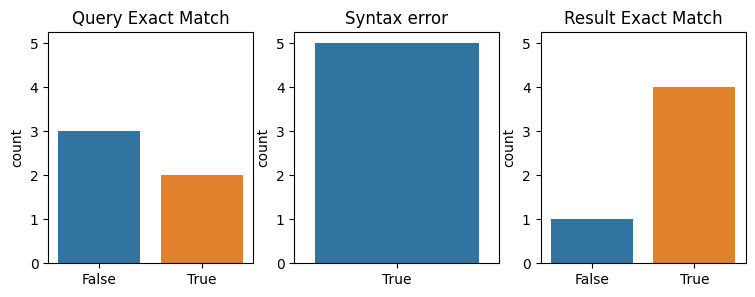

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot chart for query exact match(q_exa_match:list)
plt.figure(figsize=(9, 3))

ax1 = plt.subplot(1, 3, 1)
plt.title("Query Exact Match")
sns.countplot(x=q_exa_match)

# plot chart for query semantic_accuracy(semantic_acc:list) = result match
plt.subplot(1, 3, 2, sharey=ax1)
plt.title("Syntax error")
sns.countplot(x=syn_valid)

# plot chart for query semantic_accuracy(semantic_acc:list) = result match
plt.subplot(1, 3, 3, sharey=ax1)
plt.title("Result Exact Match")
sns.countplot(x=semantic_acc)

plt.show()

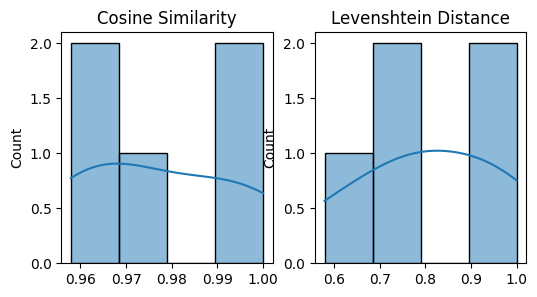

In [13]:
# plot charts for cosine similarity(cos_sim:list) and levenshtein distance(lev_score:list)
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.title("Cosine Similarity")
sns.histplot(
    cos_sim,
    kde=True,
)

plt.subplot(1, 2, 2)
plt.title("Levenshtein Distance")
sns.histplot(
    lev_score,
    kde=True,
)

plt.show()